In [36]:
import pandas as pd
import numpy as np
import pickle

In [37]:
input_path = 'H:\RediMinds\VCQI'
train = pd.read_csv(input_path+"\VCQI_clean_train.csv")
test = pd.read_csv(input_path+"\VCQI_clean_test.csv")

In [38]:
x_train = train.drop(labels=['INTRA_OP_COMPLICATIONS','PATIENTNUMBER'], axis = 'columns').copy()
y_train = train['INTRA_OP_COMPLICATIONS'].copy()
x_test = test.drop(labels=['INTRA_OP_COMPLICATIONS','PATIENTNUMBER'], axis = 'columns').copy()
y_test = test['INTRA_OP_COMPLICATIONS'].copy() 

In [39]:
print("Number of records in trainset {}".format(len(x_train)))
print("Number records in testset {}".format(len(x_test)))
print('% pos labels train {:.2f}'.format(y_train.sum()/len(y_train)))
print('% pos labels test {:.2f}'.format(y_test.sum()/len(y_test)))

Number of records in trainset 1183
Number records in testset 507
% pos labels train 0.06
% pos labels test 0.06


### Defining Pipeline

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

In [45]:
# ONE HOT CODE data for training

# Create dummy variables
with open (input_path+'\cat_col', 'rb') as fp:
    cat_col = pickle.load(fp)
    
# Pipeline for logist Classifier
numeric_features = x_train.select_dtypes('float').columns.tolist()
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),
                                     ])
categorical_pipe = Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore'))
                            ])
preprocessor_RFC = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),
                                                   ('cat', categorical_pipe, cat_col)
                                                  ], 
                                     remainder='passthrough')

In [46]:
# Pipeline for logist Classifier
numeric_features = x_train.select_dtypes('float').columns.tolist()
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),
                                      ('scaler', StandardScaler())
                                     ])
categorical_pipe = Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore'))
                            ])
preprocessor_LR = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),
                                                   ('cat', categorical_pipe, cat_col)
                                                  ], 
                                     remainder='passthrough')

# Decision Tree Classifier

In [47]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import math
DTC = DecisionTreeClassifier()
parameter_dist = {'classifier__max_features':['sqrt','log2',None],
                  'classifier__min_samples_leaf': [2,5,10,15,20], 
                  'classifier__class_weight' :['balanced'], 
                  'classifier__random_state': [1234]}  

clf = Pipeline(steps=[('preprocessor', preprocessor_RFC),
                      #('pca',PCA()),
                      ('classifier', DTC)])

classifier_DTC = GridSearchCV(clf, parameter_dist, n_jobs = -1, scoring = 'average_precision', cv = 10 )
results_classifier_DTC = classifier_DTC.fit(x_train, y_train)
y_DTC = results_classifier_DTC.predict(x_test)


In [48]:
classifier = results_classifier_DTC
results_DTC = pd.DataFrame(classifier.predict(x_test), columns=['pred_label'])
results_DTC['pred_prob'] =  pd.DataFrame(classifier.predict_proba(x_test))[1]
results_DTC['true_label'] = np.array(y_test)

In [49]:
# Decison Tree Score Raw Data
print(classifier.best_params_)
print("\n Model Best CV score: \n" + str(classifier.best_score_))
print("\n Model Balanced Accuracy: \n" + str(metrics.balanced_accuracy_score(y_test, y_DTC)))
print("\n Confusion Matrix : \n"+str(metrics.confusion_matrix(y_test, y_DTC)))
print("\n Classification Report: \n"+ str(metrics.classification_report(y_test, y_DTC)))
print("\n AUC-ROC: \n"+ str(metrics.roc_auc_score(y_test, results_DTC['pred_prob'])))

def calc_aucpr_data(result):
    y_ACTUAL = result['true_label']
    scores_prob = result['pred_prob']
    yhat = result['pred_label']
    precision, recall, thresholds = metrics.precision_recall_curve(y_ACTUAL, scores_prob, pos_label=1)
    prc_auc = metrics.auc(recall,precision)
    return prc_auc

print("\n PR-ROC: \n"+ str(calc_aucpr_data(results_DTC)))

{'classifier__class_weight': 'balanced', 'classifier__max_features': None, 'classifier__min_samples_leaf': 10, 'classifier__random_state': 1234}

 Model Best CV score: 
0.44369779629172246

 Model Balanced Accuracy: 
0.7513793617655831

 Confusion Matrix : 
[[429  50]
 [ 11  17]]

 Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.90      0.93       479
           1       0.25      0.61      0.36        28

    accuracy                           0.88       507
   macro avg       0.61      0.75      0.65       507
weighted avg       0.94      0.88      0.90       507


 AUC-ROC: 
0.7895168505815687

 PR-ROC: 
0.6151414779484408


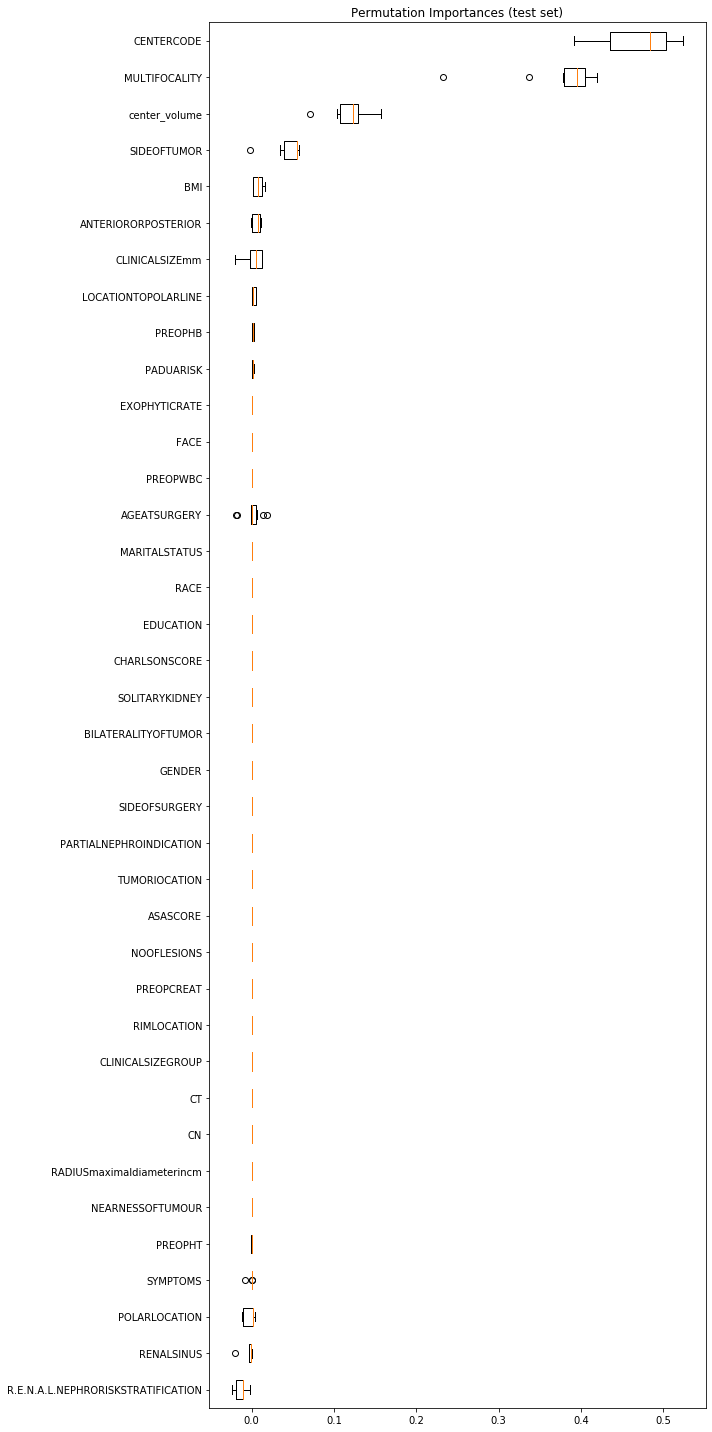

In [50]:
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
result = permutation_importance(classifier_DTC, x_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()


fig, ax = plt.subplots(figsize=(10,20))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=x_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

# Random Forest Classifier

In [51]:
# Random Forest Regressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import math
RFC = RandomForestClassifier(random_state=42)
parameter_dist = {'classifier__n_estimators': [100,200,300,500,1000], 
                  'classifier__max_features':['sqrt','log2',None],
                  'classifier__min_samples_leaf': [2,3,4,5], 
                  'classifier__class_weight' :['balanced'] 
} 

clf = Pipeline(steps=[('preprocessor', preprocessor_RFC),
                      #('pca',PCA()),
                      ('classifier', RFC)])
classifier_RFR = GridSearchCV(clf, parameter_dist, n_jobs = -1,cv=10, scoring = 'average_precision', return_train_score=True)
results_classifier_RFR = classifier_RFR.fit(x_train, y_train)


In [52]:
y_RFR = classifier_RFR.predict(x_test)
classifier = classifier_RFR
results_RFR = pd.DataFrame(classifier.predict(x_test), columns=['pred_label'])
results_RFR['pred_prob'] =  pd.DataFrame(classifier.predict_proba(x_test))[1]
results_RFR['true_label'] = np.array(y_test)

In [53]:
# Random Forest Classifier Score Raw Data
print(classifier.best_params_)
print("\n Model Best CV score: \n" + str(classifier.best_score_))
print("\n Confusion Matrix : \n"+str(metrics.confusion_matrix(y_test, y_RFR)))
print("\n Classification Report: \n"+ str(metrics.classification_report(y_test, y_RFR)))
print("\n AUC-ROC: \n"+ str(metrics.roc_auc_score(y_test, results_RFR['pred_prob'])))

def calc_aucpr_data(result):
    y_ACTUAL = result['true_label']
    scores_prob = result['pred_prob']
    yhat = result['pred_label']
    precision, recall, thresholds = metrics.precision_recall_curve(y_ACTUAL, scores_prob, pos_label=1)
    prc_auc = metrics.auc(recall,precision)
    return prc_auc

print("\n PR-ROC: \n"+ str(calc_aucpr_data(results_RFR)))
print(metrics.average_precision_score(y_test, results_RFR['pred_prob']))

{'classifier__class_weight': 'balanced', 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 3, 'classifier__n_estimators': 200}

 Model Best CV score: 
0.5166514413951859

 Confusion Matrix : 
[[477   2]
 [ 18  10]]

 Classification Report: 
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       479
           1       0.83      0.36      0.50        28

    accuracy                           0.96       507
   macro avg       0.90      0.68      0.74       507
weighted avg       0.96      0.96      0.95       507


 AUC-ROC: 
0.8577393379063525

 PR-ROC: 
0.5908715602965449
0.5939444993759931


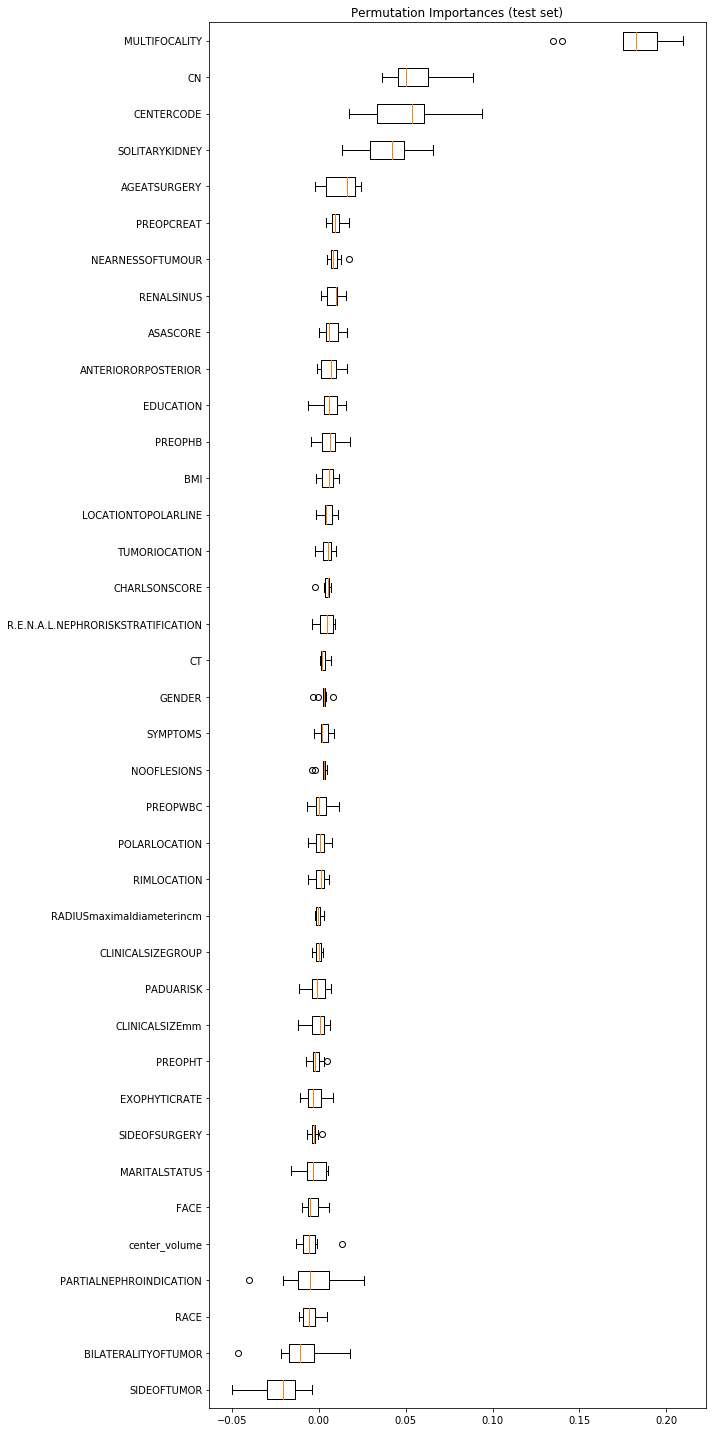

In [55]:
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
result = permutation_importance(classifier_RFR, x_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()


fig, ax = plt.subplots(figsize=(10,20))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=x_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

# Prepare data for Logistic Regression

In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import math
model = LogisticRegression()
parameter_dist = {'classifier__solver':['saga','liblinear','newton-cg','lbfgs'],
                  'classifier__penalty':['l2'],
                  'classifier__max_iter':[10000],
                  'classifier__class_weight':['balanced'],
                  'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
                 }



clf = Pipeline(steps=[('preprocessor', preprocessor_LR),
                      #('pca',PCA()),
                      ('classifier', LogisticRegression(random_state = 42))])
logit = GridSearchCV(clf,parameter_dist,n_jobs=-1,scoring= 'average_precision', cv = 10)

In [57]:
#train and fit to original data
classifier_logit = logit.fit(x_train, y_train)
y_logit = classifier_logit.predict(x_test)

In [58]:
classifier = classifier_logit
results_logit = pd.DataFrame(classifier.predict(x_test), columns=['pred_label'])
results_logit['pred_prob'] =  pd.DataFrame(classifier.predict_proba(x_test))[1]
results_logit['true_label'] = np.array(y_test)

In [59]:
# Logistic Regression Score Raw Data
print(classifier.best_params_)
print("\n Model Best CV score: \n" + str(classifier.best_score_))
print("\n Model Balanced Accuracy: \n" + str(metrics.balanced_accuracy_score(y_test, y_logit)))
print("\n Confusion Matrix : \n"+str(metrics.confusion_matrix(y_test, y_logit)))
print("\n Classification Report: \n"+ str(metrics.classification_report(y_test, y_logit)))
print("\n AUC-ROC: \n"+ str(metrics.roc_auc_score(y_test, results_logit['pred_prob'])))

def calc_aucpr_data(result):
    y_ACTUAL = result['true_label']
    scores_prob = result['pred_prob']
    yhat = result['pred_label']
    precision, recall, thresholds = metrics.precision_recall_curve(y_ACTUAL, scores_prob, pos_label=1)
    prc_auc = metrics.auc(recall,precision)
    return prc_auc

print("\n PR-ROC: \n"+ str(calc_aucpr_data(results_logit)))
print(metrics.average_precision_score(y_test, results_logit['pred_prob']))

{'classifier__C': 0.1, 'classifier__class_weight': 'balanced', 'classifier__max_iter': 10000, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cg'}

 Model Best CV score: 
0.36280942314118925

 Model Balanced Accuracy: 
0.7526468833880108

 Confusion Matrix : 
[[396  83]
 [  9  19]]

 Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.83      0.90       479
           1       0.19      0.68      0.29        28

    accuracy                           0.82       507
   macro avg       0.58      0.75      0.59       507
weighted avg       0.93      0.82      0.86       507


 AUC-ROC: 
0.8256039367730391

 PR-ROC: 
0.3700865593190854
0.37819797169816866


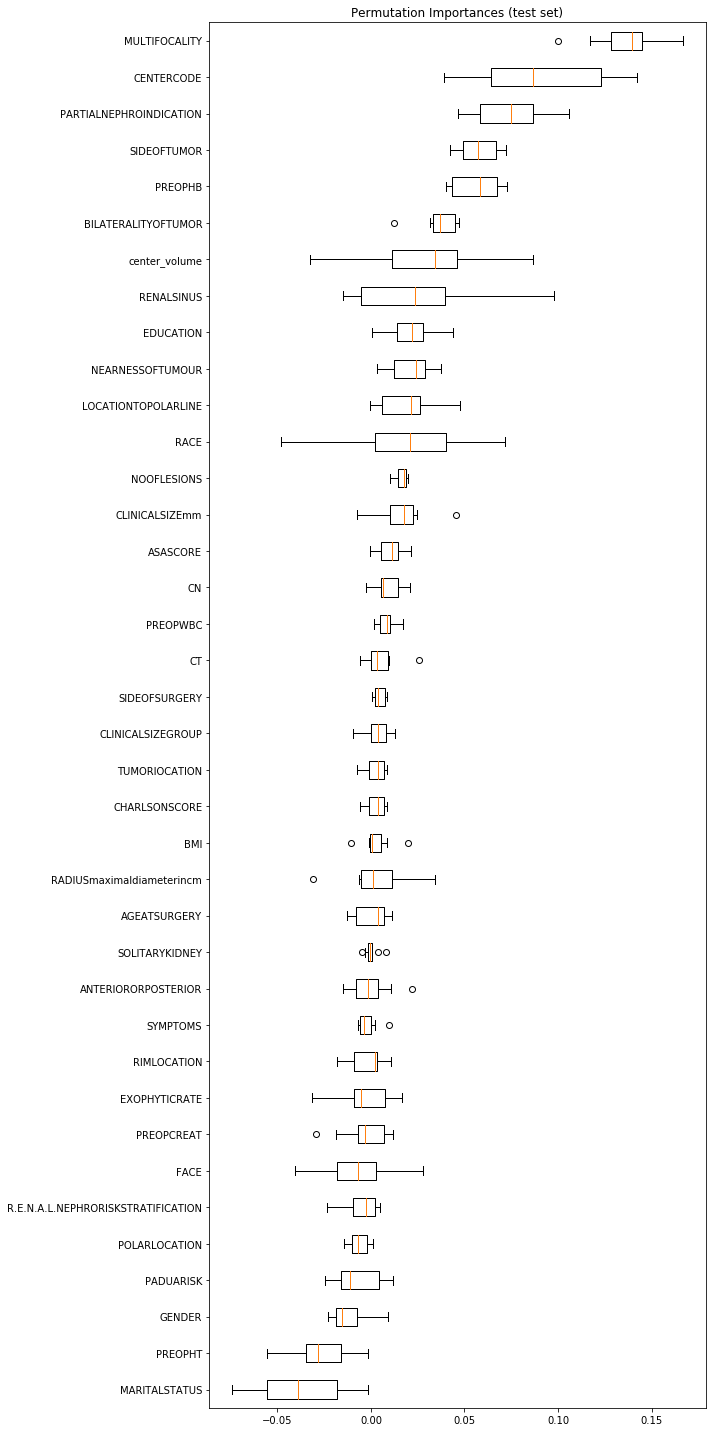

In [60]:
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
result = permutation_importance(classifier_logit, x_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()


fig, ax = plt.subplots(figsize=(10,20))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=x_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

# Compare Classifiers

C:\Users\anubhav\Anaconda3\envs\Tensorflow\lib\site-packages\ipykernel_launcher.py:59: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


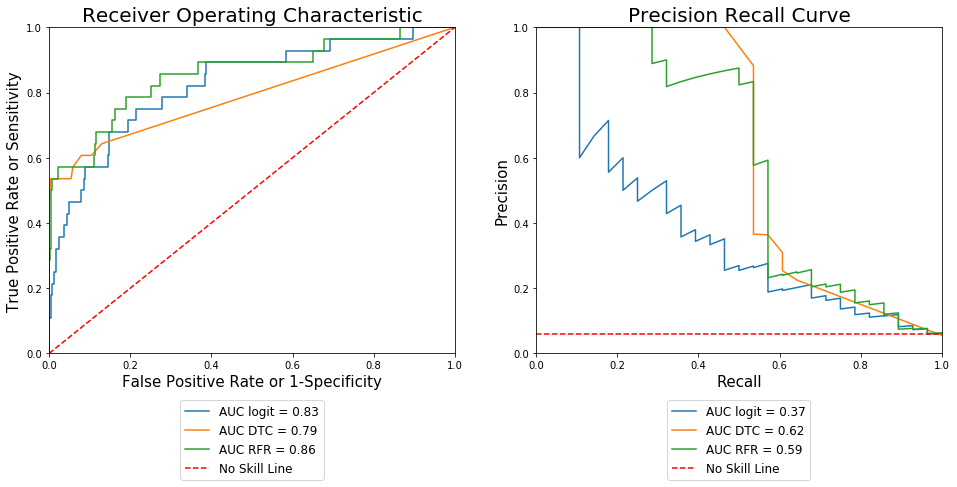

In [67]:
# Plotting AUROC Curve - Calculatae Metrics
from sklearn import metrics
def calc_aucroc_data(result):
    y_ACTUAL= result['true_label']
    scores_prob = result['pred_prob']
    fpr, tpr, thresholds = metrics.roc_curve(y_ACTUAL, scores_prob, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    return fpr, tpr, thresholds, roc_auc

def calc_aucpr_data(result):
    y_ACTUAL = result['true_label']
    scores_prob = result['pred_prob']
    yhat = result['pred_label']
    precision, recall, thresholds = metrics.precision_recall_curve(y_ACTUAL, scores_prob, pos_label=1)
    prc_auc = metrics.auc(recall,precision)
    f1 = metrics.f1_score(y_ACTUAL, yhat)
    ap = metrics.average_precision_score(y_ACTUAL, yhat)
    postives_ratio = round(sum(result['true_label'])/(len(result['true_label'])),2)
    return recall, precision, f1, prc_auc, postives_ratio

fpr_logit, tpr_logit, thresholds_logit, roc_auc_logit = calc_aucroc_data(results_logit)
recall_logit, precision_logit, f1_logit, prc_auc_logit, postives_ratio_logit = calc_aucpr_data(results_logit)

fpr_DTC, tpr_DTC, thresholds_DTC, roc_auc_DTC = calc_aucroc_data(results_DTC)
recall_DTC, precision_DTC, f1_DTC, prc_auc_DTC, postives_ratio_DTC = calc_aucpr_data(results_DTC)

fpr_RFR, tpr_RFR, thresholds_RFR, roc_auc_RFR = calc_aucroc_data(results_RFR)
recall_RFR, precision_RFR, f1_RFR, prc_auc_RFR, postives_ratio_RFR = calc_aucpr_data(results_RFR)


import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6))

# Plotting AUROC Curve - Plot Curve
ax1.set_title('Receiver Operating Characteristic',fontdict={"size":20})
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax1.set_ylabel('True Positive Rate or Sensitivity', fontdict={"size":15})
ax1.set_xlabel('False Positive Rate or 1-Specificity',fontdict={"size":15})
ax1.plot(fpr_logit, tpr_logit, label = 'AUC logit = %0.2f' % roc_auc_logit)
ax1.plot(fpr_DTC, tpr_DTC, label = 'AUC DTC = %0.2f' % roc_auc_DTC)
ax1.plot(fpr_RFR, tpr_RFR, label = 'AUC RFR = %0.2f' % roc_auc_RFR)
ax1.plot([0, 1], [0, 1],linestyle='--',color='red', label = 'No Skill Line')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.125), fontsize = 12)  

# Plotting Precision-Recall Curve - PLot Curve
ax2.set_title('Precision Recall Curve',fontdict={"size":20})
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
ax2.set_ylabel('Precision',fontdict={"size":15})
ax2.set_xlabel('Recall',fontdict={"size":15})
ax2.plot(recall_logit, precision_logit, label = 'AUC logit = %.2f' % (prc_auc_logit))
ax2.plot(recall_DTC, precision_DTC, label = 'AUC DTC = %.2f' % (prc_auc_DTC))
ax2.plot(recall_RFR, precision_RFR, label = 'AUC RFR = %.2f' % (prc_auc_RFR))
positive_class_ratio = postives_ratio_RFR
ax2.plot([0, 1], [positive_class_ratio, positive_class_ratio],linestyle='--',color='red', label = 'No Skill Line')
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.125),fontsize = 12)

fig.show()



In [61]:
output_path = 'output/models'

In [62]:
import os
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [63]:
# Export Decision Tree Classifier with Pipeline
from joblib import dump
dump(classifier_DTC, output_path+'/DTC.joblib')

['output/models/DTC.joblib']

In [64]:
# Export Random Forest Classifer with Pipeline
from joblib import dump
dump(classifier_RFR, output_path+'/RFR.joblib')

['output/models/RFR.joblib']

In [65]:
# Export LOgistic Classifer with Pipeline
from joblib import dump
dump(classifier_logit, output_path+'/Logit.joblib')

['output/models/Logit.joblib']

['output/models/OHE.joblib']